In [1]:
#DOWNLOAD OPEN CV
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#link colab den drive 
# tao thu muc và đẩy image lên để lát đọc ra

Mounted at /content/gdrive


In [2]:
import numpy as np
from google.colab.patches import cv2_imshow
import math
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline


In [46]:
def edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #covert về ảnh xám để dễ xác định biên
    img_gaussian = cv.GaussianBlur(gray, (blur_ksize, blur_ksize), 0) #lọc gauss để giảm nhiễu
    cv2_imshow(img_gaussian)
    img_canny = cv.Canny(img_gaussian, threshold1, threshold2) #tách biên
    return img_canny
    
#hàm tính góc dựa trên 2 vecto chỉ phương
def angle(vector1, vector2):
    if vector1 == vector2:
      return 0
    else:
      x1, y1 = vector1
      x2, y2 = vector2
      inner_product = x1*x2 + y1*y2
      len1 = math.hypot(x1, y1)
      len2 = math.hypot(x2, y2)
      return math.acos(inner_product/(len1*len2))

def calculate(pt1, pt2):
    a = angle(pt1, pt2)
    if a == 0:
      return 0
    return abs(math.degrees(a))

In [6]:
cd gdrive/MyDrive/B1-CV

/content/gdrive/MyDrive/B1-CV


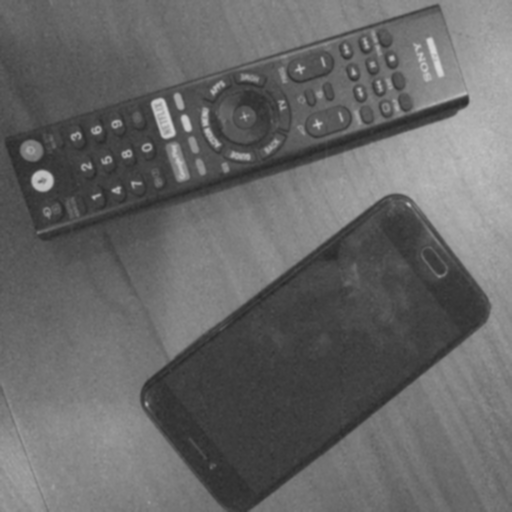

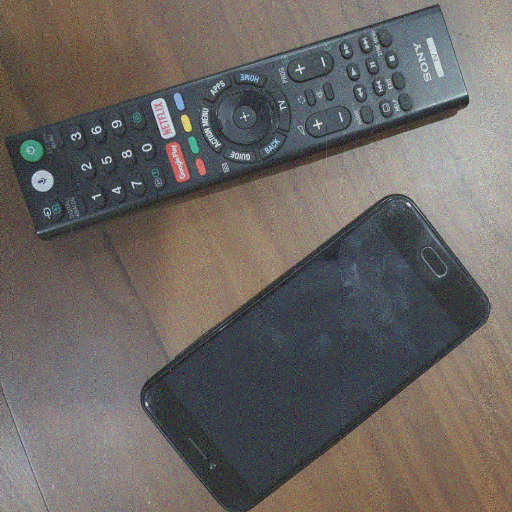

In [48]:
# img = cv.imread('img4.png', 1)
# img = cv.imread('img3_bruit.png', 1)
img = cv.imread('img3_bruit2.png', 1)
# img = cv.imread('img3_add.png', 0)

edges_newF = edge_detection(img, 5, 70, 200)
cv2_imshow(img)

In [26]:
#đang thử IDFT cho ảnh 4
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

error: ignored

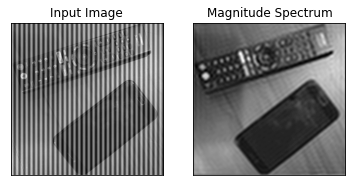

In [23]:
#đang thử IDFT cho ảnh 4
rows, cols = img.shape

crow,ccol = int(rows/2) , int(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

edges_newF = img_back

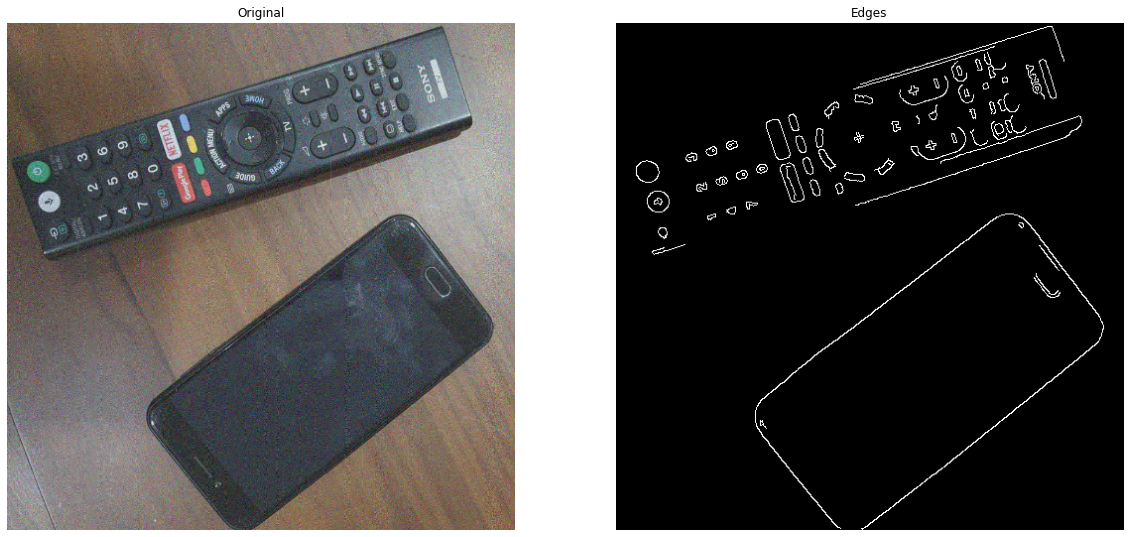

In [49]:
#hiển thị ảnh gốc và ảnh sau khi tách biên
f, axarr = plt.subplots(1,2,figsize=(20, 20))
[axi.set_axis_off() for axi in axarr.ravel()]
axarr[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
axarr[0].set_title("Original")
axarr[1].imshow(edges_newF, cmap=plt.get_cmap('gray'))
axarr[1].set_title("Edges")
f.show()

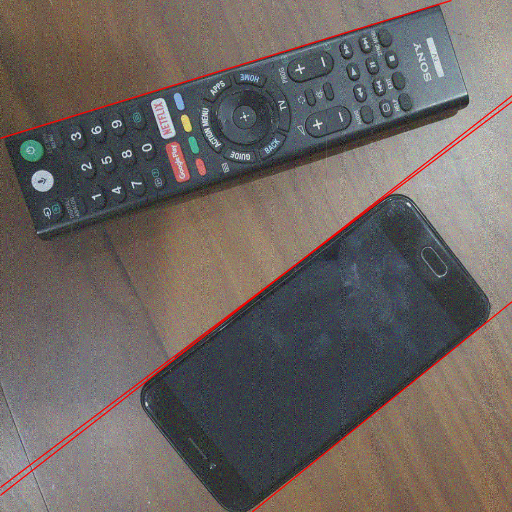

In [42]:
cdst = img.copy()

VTCPs = [] #tap hop vecto chi phuong

lines = cv.HoughLines(edges_newF, 1, np.pi / 180, 150, None, 0, 0) #dùng hàm houghLines để lấy được ra các đường thẳng tương ứng với biên
# lines = cv.HoughLinesP(edges_newF, 1, np.pi / 180, 150, None, 150, 10)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a))) #điểm đầu đường thẳng
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a))) #điểm cuối
        VTCPs.append((pt2[0] - pt1[0], pt2[1] - pt1[1])) #tính vtcp và lưu nó vào mảng
        cv.line(cdst, pt1, pt2, (0,0,255), 1, cv.LINE_AA) #vẽ đường thẳng màu đỏ lên img gốc đã copy

cv2_imshow(cdst)       


In [38]:
print(VTCPs)
listAngle = []
a = 0
#tính tất cả góc của đôi một vtcp 
for i in range(0, len(VTCPs) - 1):
  for j in range(1, len(VTCPs)):
    if i != j:
      # print(i , j)
      angleTmp = calculate(VTCPs[i], VTCPs[j])
      listAngle.append(angleTmp)

print(listAngle)


[(1911, -584), (1554, -1258), (1901, -617), (1575, -1230), (1596, -1203), (1575, -1231), (1901, -617)]
[21.997885622382523, 0.9885604647091082, 20.99503330540195, 20.01439515631585, 21.017623138334702, 0.9885604647091082, 21.009325157673214, 1.0028523169803778, 1.983490466066643, 0.9802624840478049, 21.009325157673214, 21.009325157673214, 20.00647284069264, 19.025834691606534, 20.029062673625383, 0, 1.0028523169803778, 20.00647284069264, 0.9806381490862681, 0.022589832937871073, 20.00647284069264, 1.983490466066643, 19.025834691606534, 0.9806381490862681, 1.0032279820191687, 19.025834691606534, 0.9802624840478049, 20.029062673625383, 0.022589832937871073, 1.0032279820191687, 20.029062673625383]


In [39]:
#lấy gtri max
print(max(listAngle))

21.997885622382523
